In [1]:
import numpy as np 
import os
#from PIL import image
import matplotlib.pyplot as plt 
#import matplotlib.image as npimg
from sklearn.utils import shuffle
#from sklearn.model_selection import train_test_split
from imgaug import augmenters  as iaa
import cv2
#import ntpath
import random
from google.colab import drive
import tensorflow as tf

In [2]:
#mount google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#load dataset from google drive
train_data = np.load('drive/My Drive/PilotNet/Merged_Data/3-merge-456.npy', allow_pickle=True)

In [4]:
WIDTH = 187
HEIGHT = 335

In [5]:
def map (x, in_min, in_max, out_min, out_max):
  mapped_out = (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min
  return mapped_out

(12200, 2)
Steering:  2052
Throttle:  943


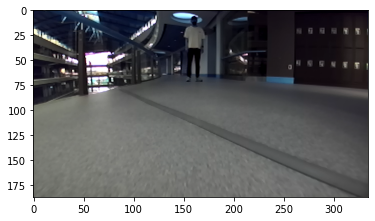

In [6]:
print(train_data.shape)
index = random.randint(0,len(train_data)-1)
image, output = train_data[index]

image = cv2.resize(image,(335,187))

plt.imshow(image)
print("Steering: ", output[0])
print("Throttle: ", output[1])

In [7]:
train_data_temp = []

count = 0

for i in range(len(train_data)):

  

  #extract image,steering and throttle] 
  image, output = train_data [i]
  #convert images from BRG to RGB channels
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  
  if output[0] < 1365:
     output[0] = 1365
  if output[0] > 2730:
     output[0] = 2730
     #count = count + 1
     #print(i)

  #limit steering to -1 to 1
  if output[0]<2047.5:
    output [0] = map(output[0], 1365, 2047.5, -1, 0)
  elif output[0]>2047.5:
    output [0] = map(output[0], 2047.5, 2730, 0, 1)
  else:
    output [0] = 0
  
  #limit throttle to 0 to 1
  output[1] = map (output[1], 0, 1050, 0, 1)
  
  image = cv2.resize(image,(335,187))

  train_data_temp.append([image, output])

train_data = np.array(train_data_temp)
train_data_temp = []

#print(count)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(12200, 2)
Steering:  0.006593406593406593
Throttle:  0.8980952380952381


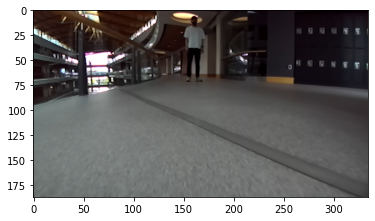

In [8]:

print(train_data.shape)
image, output = train_data[index]
#image, output = train_data[4223]

plt.imshow(image)
print("Steering: ", output[0])
print("Throttle: ", output[1])


In [9]:
#seperate data into steering and throttle 
steering = []
throttle = []

for data in train_data:
  image = data [0]
  steering_data = data [1][0]
  throttle_data = data [1][1]
  steering.append(steering_data)
  throttle.append(throttle_data)

steering = np.array(steering)
throttle = np.array(throttle)

Text(0, 0.5, 'Number of labelled images')

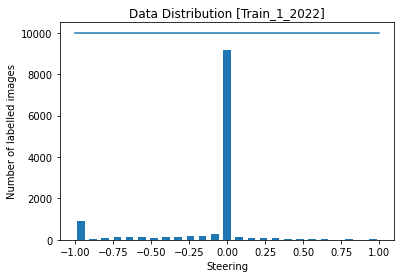

In [10]:
num_bins = 25
samples_per_bin = 10000
#samples_per_bin = 5000
hist, bins = np.histogram(steering, num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width= 0.05)
plt.plot((np.min(steering), np.max(steering)), (samples_per_bin, samples_per_bin))
#plt.plot((-1,1), (samples_per_bin, samples_per_bin))
plt.title('Data Distribution [Train_1_2022]')
plt.xlabel('Steering')
plt.ylabel('Number of labelled images')

In [11]:
print(num_bins)
print(np.min(steering))
print(len(steering))
print(bins)
print(len(bins))

25
-1.0
12200
[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]
26


In [12]:
#Balance the data
print ('total data:', len(train_data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(steering)):
    if steering[i]>= bins[j] and steering[i]<=bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  #print(list_)
  if len(list_)>samples_per_bin:
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)

print ('removed', len(remove_list))

train_data = np.delete(train_data, remove_list, axis=0)

print ('remaining:', len (train_data))

total data: 12200
removed 0
remaining: 12200


In [13]:
#seperate balanced data into steering and throttle 
steering = []
throttle = []

for data in train_data:
  image = data [0]
  steering_data = data [1][0]
  throttle_data = data [1][1]
  steering.append(steering_data)
  throttle.append(throttle_data)

steering = np.array(steering)
throttle = np.array(throttle)

Text(0, 0.5, 'Number of labelled images')

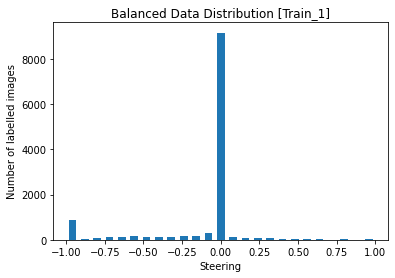

In [14]:
num_bins = 25
hist, bins = np.histogram(steering, num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width= 0.05)
plt.title('Balanced Data Distribution [Train_1]')
plt.xlabel('Steering')
plt.ylabel('Number of labelled images')

In [15]:
#function to flip the image and steering angle
def img_random_flip(image, choice):
  image = cv2.flip(image, 1)
  steering=choice[0]
  throttle=choice[1]
  steering = -steering
  new_choice = [steering, throttle]
  return image, new_choice

actual steering angle =  0.006593406593406593
flipped steering angle =  -0.006593406593406593


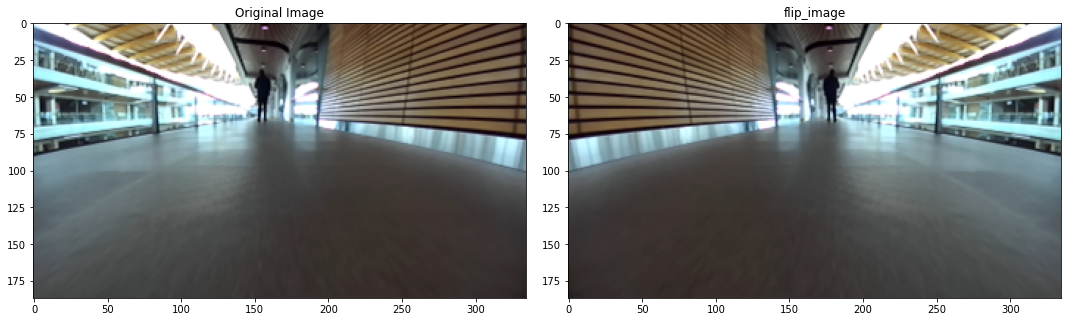

In [16]:
#fix the naming 
image, choice = train_data [random.randint(0,len(train_data)-1)]
flip_image, flip_choice = img_random_flip(image, choice)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(image)
axs[0].set_title('Original Image')

axs[1].imshow(flip_image)
axs[1].set_title('flip_image')

print ("actual steering angle = ", choice [0])
print ("flipped steering angle = ", flip_choice [0])
#print (choice)

In [17]:
#comment
"""
#add augmented data to the dataset
temp_train_data = []
for data in train_data:
  image = data [0]
  choice = data [1]
  flipped_image, flipped_choice = img_random_flip(image, choice)
  temp_train_data.append([flipped_image, flipped_choice])

temp_train_data =np.array(temp_train_data)
train_data = np.concatenate((train_data,temp_train_data))
"""

'\n#add augmented data to the dataset\ntemp_train_data = []\nfor data in train_data:\n  image = data [0]\n  choice = data [1]\n  flipped_image, flipped_choice = img_random_flip(image, choice)\n  temp_train_data.append([flipped_image, flipped_choice])\n\ntemp_train_data =np.array(temp_train_data)\ntrain_data = np.concatenate((train_data,temp_train_data))\n'

In [18]:
print ("New Size of Training Data:", len(train_data))
train_data = shuffle(train_data)

New Size of Training Data: 12200


In [19]:
#seperate artificially expanded data into steering and throttle 
train_data = shuffle(train_data)
steering = []
throttle = []

for data in train_data:
  image = data [0]
  steering_data = data [1][0]
  throttle_data = data [1][1]
  steering.append(steering_data)
  throttle.append(throttle_data)

steering = np.array(steering)
throttle = np.array(throttle)

Text(0, 0.5, 'Number of labelled images')

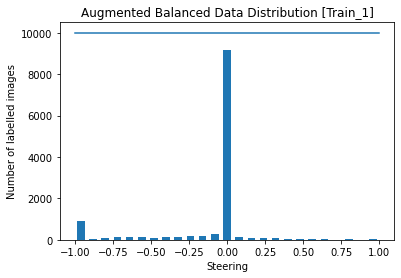

In [20]:
#Plot expanded-balanced Steering Data
num_bins = 25
samples_per_bin = 10000
hist, bins = np.histogram(steering, num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width= 0.05)
plt.plot((np.min(steering), np.max(steering)), (samples_per_bin, samples_per_bin))
plt.title('Augmented Balanced Data Distribution [Train_1]')
plt.xlabel('Steering')
plt.ylabel('Number of labelled images')

In [21]:
#Balance the data
print ('total data:', len(train_data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(steering)):
    if steering[i]>= bins[j] and steering[i]<=bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  #print(list_)
  if len(list_)>samples_per_bin:
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)

print ('removed', len(remove_list))

train_data = np.delete(train_data, remove_list, axis=0)

print ('remaining:', len (train_data))

total data: 12200
removed 0
remaining: 12200


In [22]:
#seperate balanced data into steering and throttle 
steering = []
throttle = []

for data in train_data:
  image = data [0]
  steering_data = data [1][0]
  throttle_data = data [1][1]
  steering.append(steering_data)
  throttle.append(throttle_data)

steering = np.array(steering)
throttle = np.array(throttle)

Text(0, 0.5, 'Number of labelled images')

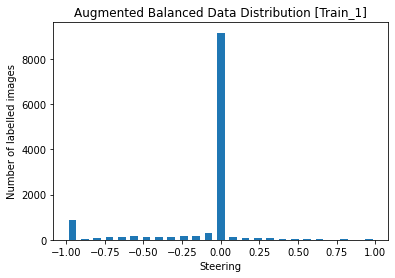

In [23]:
num_bins = 25
hist, bins = np.histogram(steering, num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width= 0.05)
plt.title('Augmented Balanced Data Distribution [Train_1]')
plt.xlabel('Steering')
plt.ylabel('Number of labelled images')

In [24]:
#Split the dataset
#95% train
#5% test
train = train_data[:-round(len(train_data)*0.05)] 
test = train_data[-round(len(train_data)*0.05):]
print("train: ", train.shape)
print("test: ", test.shape)


'''
for data in train_data:
  image = data [0]
  steering_data = data [1][0]
  throttle_data = data [1][1]
  steering.append(steering_data)
  throttle.append(throttle_data)
'''

X = []
Y = []

for data in train:
  image = data[0]
  steering = data[1][0]
  X.append(image)
  Y.append(steering)


X = np.array(X)
Y = np.array(Y)


test_x = []
test_y = []

for data in test:
  image = data[0]
  steering = data[1][0]
  test_x.append(image)
  test_y.append(steering)

test_x = np.array(test_x)
test_y = np.array(test_y)


train:  (11590, 2)
test:  (610, 2)


In [25]:

def zoom(image):
  zoom_img = iaa.Affine(scale = (1, 1.3))
  image = zoom_img.augment_image(image)
  return image


In [26]:
'''
image, choice = train [random.randint(0,len(train)-1)]
zoomed_image = zoom(image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(image)
axs[0].set_title('Original Image')
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')
'''

"\nimage, choice = train [random.randint(0,len(train)-1)]\nzoomed_image = zoom(image)\n\nfig, axs = plt.subplots(1, 2, figsize=(15, 10))\nfig.tight_layout()\naxs[0].imshow(image)\naxs[0].set_title('Original Image')\naxs[1].imshow(zoomed_image)\naxs[1].set_title('Zoomed Image')\n"

In [27]:

def pan(image):
  pan = iaa.Affine(translate_percent={'x': (-0.1, 0.1), 'y': (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image


In [28]:
'''
image, choice = train [random.randint(0,len(train)-1)]
#original_image = npimg.imread(image)
panned_image = pan(image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(image)
axs[0].set_title('Original Image')
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')
'''

"\nimage, choice = train [random.randint(0,len(train)-1)]\n#original_image = npimg.imread(image)\npanned_image = pan(image)\n\nfig, axs = plt.subplots(1, 2, figsize=(15, 10))\nfig.tight_layout()\naxs[0].imshow(image)\naxs[0].set_title('Original Image')\naxs[1].imshow(panned_image)\naxs[1].set_title('Panned Image')\n"

In [29]:

def img_random_brightness(image):
  brightness = iaa.Multiply((0.8, 1.2))
  image = brightness.augment_image(image)
  return image


In [30]:
'''
image, choice = train_data [random.randint(0,len(train_data)-1)]
bright_image = img_random_brightness(image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(image)
axs[0].set_title('Original Image')

axs[1].imshow(bright_image)
axs[1].set_title('bright_image')
'''

"\nimage, choice = train_data [random.randint(0,len(train_data)-1)]\nbright_image = img_random_brightness(image)\n\nfig, axs = plt.subplots(1, 2, figsize=(15, 10))\nfig.tight_layout()\naxs[0].imshow(image)\naxs[0].set_title('Original Image')\n\naxs[1].imshow(bright_image)\naxs[1].set_title('bright_image')\n"

In [31]:

def random_augment(image, choice):
    #image = npimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    return image, choice


In [32]:
'''
image, choice = train_data [random.randint(0,len(train_data)-1)]
random_augmented_image, augmented_choice = random_augment(image, choice)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(image) #cmap='gray'
axs[0].set_title('Original Image')

axs[1].imshow(random_augmented_image) 
axs[1].set_title('Random Augmented Image')
'''

"\nimage, choice = train_data [random.randint(0,len(train_data)-1)]\nrandom_augmented_image, augmented_choice = random_augment(image, choice)\n\nfig, axs = plt.subplots(1, 2, figsize=(15, 10))\nfig.tight_layout()\naxs[0].imshow(image) #cmap='gray'\naxs[0].set_title('Original Image')\n\naxs[1].imshow(random_augmented_image) \naxs[1].set_title('Random Augmented Image')\n"

In [33]:

def batch_generator(train_data_to_generate, batch_size, istraining):
  while True:
    batch_img = []
    batch_ch = []

    for i in range(batch_size):
      random_index = random.randint(0, len(train_data_to_generate)-1)
      image, choice = train_data_to_generate[random_index]

      if istraining:
        im, ch= random_augment(image, choice)
        #ch = choice
      else:
        im = image
        ch = choice
      
      im = im.reshape(WIDTH,HEIGHT,3)

      batch_img.append(im)
      batch_ch.append(ch)
    yield (np.asarray(batch_img), np.asarray(batch_ch))


In [34]:
import keras
from keras.models import Sequential
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, LSTM, Reshape, Input, Concatenate, ZeroPadding2D, GlobalMaxPool2D
from keras.models import Model
from keras.models import load_model
import os, os.path

In [35]:
def nvidia_modified():
  model = Sequential()

  #1st layer
  model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(WIDTH, HEIGHT,3),activation='relu'))

  #2nd layer
  model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='relu'))

  #3rd layer
  model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='relu'))
  
  #4th layer
  model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))

  #5th layer
  model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))


  #1st Dense Layer
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  #model.add(Dropout(0.5))

  #2nd Dense Layer
  model.add(Dense(50, activation='relu'))
  #model.add(Dropout(0.5))

  #3rd Dense Layer
  model.add(Dense(10, activation='relu'))
  #model.add(Dropout(0.5))

  #output
  model.add(Dense(1))
  
  #Compile model
  model.compile(Adam(learning_rate=0.001), loss = 'mse')
  return model

In [36]:
DIR = 'drive/My Drive/PilotNet/trained_weights'
check_point = len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))])
print(check_point)

3


In [37]:

#testing model with augmentation 
if check_point == 2:
  #create model and train it
  model = nvidia_modified() 
  print("Building New Model...")
  print(model.summary())
else:
  #load previous model and continue training
  file_name = 'drive/My Drive/PilotNet/trained_weights/ADP_straight{}.h5'.format(check_point-1)
  print(file_name)
  #file_name = 'drive/My Drive/PilotNet/trained_weights/ADP_straight{}.h5'.format(check_point)
  model = load_model(file_name)
  print("Loading Previously Trained Model...")
  print(model.summary()) 


drive/My Drive/PilotNet/trained_weights/ADP_straight2.h5
Loading Previously Trained Model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 92, 166, 24)       1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 81, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 39, 48)        43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 18, 37, 64)        27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 35, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 35840)             0         
                             

In [38]:
print(X.shape)
print(Y.shape)

print(test_x.shape)
print(test_y.shape)

(11590, 187, 335, 3)
(11590,)
(610, 187, 335, 3)
(610,)


In [39]:
'''
#with augmentation 
history = model.fit(batch_generator(train,32,1),
                              steps_per_epoch = 100,
                              epochs = 10,
                              validation_data = batch_generator(test, 32, 0),
                              validation_steps = 50,
                              verbose = 1, 
                              shuffle=1)
'''

'\n#with augmentation \nhistory = model.fit(batch_generator(train,32,1),\n                              steps_per_epoch = 100,\n                              epochs = 10,\n                              validation_data = batch_generator(test, 32, 0),\n                              validation_steps = 50,\n                              verbose = 1, \n                              shuffle=1)\n'

In [40]:

#without augmentation 
history = model.fit(x=X, y=Y,
                    batch_size=32,
                    epochs=10, 
                    verbose=1,
                    validation_data=(test_x, test_y), 
                    shuffle=True)


Epoch 1/10
363/363 [==============================] - 20s 26ms/step - loss: 0.1058 - val_loss: 0.0912
Epoch 2/10
363/363 [==============================] - 9s 25ms/step - loss: 0.0993 - val_loss: 0.0901
Epoch 3/10
363/363 [==============================] - 9s 25ms/step - loss: 0.0988 - val_loss: 0.0901
Epoch 4/10
363/363 [==============================] - 10s 27ms/step - loss: 0.0988 - val_loss: 0.0901
Epoch 5/10
363/363 [==============================] - 9s 26ms/step - loss: 0.0988 - val_loss: 0.0901
Epoch 6/10
363/363 [==============================] - 9s 26ms/step - loss: 0.0988 - val_loss: 0.0901
Epoch 7/10
363/363 [==============================] - 9s 26ms/step - loss: 0.0988 - val_loss: 0.0901
Epoch 8/10
363/363 [==============================] - 10s 26ms/step - loss: 0.0988 - val_loss: 0.0902
Epoch 9/10
363/363 [==============================] - 10s 27ms/step - loss: 0.0988 - val_loss: 0.0901
Epoch 10/10
363/363 [==============================] - 9s 26ms/step - loss: 0.0988 - va

In [41]:
print(Y[4],Y[5],Y[6],Y[7])

0.006593406593406593 0.006593406593406593 -0.00512820512820511 0.006593406593406593


In [42]:
#cant plot accuracy of mse

'''
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')
'''

"\nplt.plot(history.history['accuracy'])\nplt.plot(history.history['val_accuracy'])\nplt.legend(['training', 'validation'])\nplt.title('Accuracy')\nplt.xlabel('epoch')\n"

Text(0.5, 0, 'Epoch')

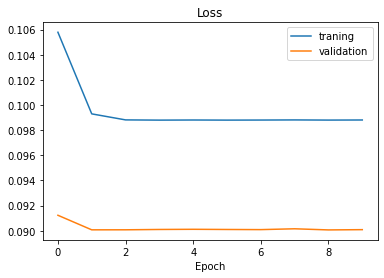

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['traning', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [44]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_x, test_y, batch_size=10)
print("test loss", results)

Evaluate on test data
61/61 [==============================] - 1s 6ms/step - loss: 0.0901
test loss 0.09008744359016418


Actual:  -0.00512820512820511
Prediction:  -0.10384057
[[-0.10384057]]


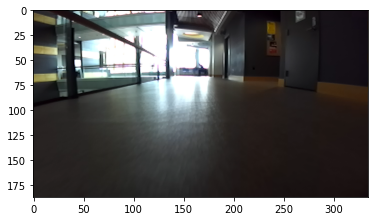

In [45]:
img_testing, choice_testing = test [random.randint(0,len(test)-1)]
plt.imshow(img_testing)
print ("Actual: ", choice_testing[0])
img_testing = img_testing.reshape(-1,WIDTH,HEIGHT,3)

print ("Prediction: ", model.predict(img_testing)[0][0])
print(model.predict(img_testing))

In [46]:
DIR = 'drive/My Drive/PilotNet/trained_weights'
check_point = len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))])
print(check_point)
file_name = 'drive/My Drive/PilotNet/trained_weights/ADP_straight{}.h5'.format(check_point)

print(file_name)

3
drive/My Drive/PilotNet/trained_weights/ADP_straight3.h5


In [47]:
model.save(file_name)